In [1]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import backend, layers, metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:

# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

# Define dataset-related functions
ROOT = "./Data/"

def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def split_dataset(directory, split=0.9):
    folders = os.listdir(directory)
    num_train = int(len(folders) * split)
    random.shuffle(folders)
    train_list, test_list = {}, {}
    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files
    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files
    return train_list, test_list

def create_triplets(directory, folder_list, max_files=100):
    if not folder_list:
        return []
    triplets = []
    folders = list(folder_list.keys())
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
        for i in range(num_files - 1):
            for j in range(i + 1, num_files):
                anchor = (folder, files[i])
                positive = (folder, files[j])
                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_files = os.listdir(os.path.join(directory, neg_folder))
                neg_file = random.choice(neg_files)
                negative = (neg_folder, neg_file)
                triplets.append((anchor, positive, negative))
    random.shuffle(triplets)
    return triplets

def get_batch(triplet_list, batch_size=256, preprocess=True):
    if not triplet_list:
        return
    batch_steps = len(triplet_list) // batch_size
    for i in range(batch_steps + 1):
        anchor, positive, negative = [], [], []
        j = i * batch_size
        while j < (i + 1) * batch_size and j < len(triplet_list):
            try:
                a, p, n = triplet_list[j]
                anchor.append(read_image(a))
                positive.append(read_image(p))
                negative.append(read_image(n))
            except FileNotFoundError as e:
                print(e)
                j += 1
                continue
            j += 1
        if not anchor or not positive or not negative:
            continue
        anchor, positive, negative = np.array(anchor), np.array(positive), np.array(negative)
        if preprocess:
            anchor, positive, negative = preprocess_input(anchor), preprocess_input(positive), preprocess_input(negative)
        yield [anchor, positive, negative]

# Prepare the dataset
train_list, test_list = split_dataset(ROOT, split=0.9)
train_triplet = create_triplets(ROOT, train_list)


def get_encoder(input_shape):
    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    for i in range(len(pretrained_model.layers) - 27):
        pretrained_model.layers[i].trainable = False
    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model


class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return ap_distance, an_distance


def get_siamese_network(input_shape=(128, 128, 3)):
    encoder = get_encoder(input_shape)
    anchor_input = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    siamese_network = Model(
        inputs=[anchor_input, positive_input, negative_input],
        outputs=distances,
        name="Siamese_Network"
    )
    return siamese_network


class SiameseModel(Model):
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]


In [3]:
# Prepare the dataset
train_list, test_list = split_dataset(ROOT, split=0.9)
train_triplet = create_triplets(ROOT, train_list)

In [5]:
# Training and evaluation loop
save_all = False
epochs = 10
batch_size = 128
weights_path = "siamese_model.h5"
max_acc = float('inf')  # Set to a high value to ensure saving after the first epoch
train_loss = []
test_metrics = []

# Assuming get_siamese_network() and SiameseModel are defined elsewhere
siamese_network = get_siamese_network()
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

# Build the model by defining the input shape
siamese_model.build([(None, 128, 128, 3),  # anchor input shape
                     (None, 128, 128, 3),  # positive input shape
                     (None, 128, 128, 3)]) # negative input shape

# Call the model to create variables before loading weights
siamese_model([tf.random.normal([1, 128, 128, 3]), 
               tf.random.normal([1, 128, 128, 3]), 
               tf.random.normal([1, 128, 128, 3])])
# Load model weights if they exist
if os.path.exists(weights_path):
    print(f"Loading weights from {weights_path}")
    siamese_model.load_weights(weights_path)
    print(f"Loading weights from {weights_path} successfully")
else:
    print("No saved weights found. Starting from scratch.")

# Training loop
for epoch in range(1, epochs + 1):
    t = time.time()
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        if data is None or len(data[0]) == 0 or len(data[1]) == 0 or len(data[2]) == 0:
            continue  # Skip empty batches
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    if len(epoch_loss) == 0:
        print("No valid batches found for training in this epoch.")
        continue
    epoch_loss = sum(epoch_loss) / len(epoch_loss)
    train_loss.append(epoch_loss)
    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time() - t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")

    # Save model weights if accuracy improves or if save_all is True
    if save_all or epoch_loss < max_acc:
        siamese_model.save_weights(weights_path)
        max_acc = epoch_loss

# Save the model weights in HDF5 format
weights_path_h5 = "siamese_model_weights_final.h5"
siamese_model.save_weights(weights_path_h5)
print("Training complete. Model weights saved in HDF5 format.")

Loading weights from siamese_model.h5
Loading weights from siamese_model.h5 successfully

EPOCH: 1 	 (Epoch done in 728 sec)
Loss on train    = 0.01853

EPOCH: 2 	 (Epoch done in 1015 sec)
Loss on train    = 0.00721

EPOCH: 3 	 (Epoch done in 1951 sec)
Loss on train    = 0.00336

EPOCH: 4 	 (Epoch done in 1951 sec)
Loss on train    = 0.00386

EPOCH: 5 	 (Epoch done in 1241 sec)
Loss on train    = 0.00086

EPOCH: 6 	 (Epoch done in 742 sec)
Loss on train    = 0.00045

EPOCH: 7 	 (Epoch done in 732 sec)
Loss on train    = 0.00049

EPOCH: 8 	 (Epoch done in 753 sec)
Loss on train    = 0.00049

EPOCH: 9 	 (Epoch done in 761 sec)
Loss on train    = 0.00054

EPOCH: 10 	 (Epoch done in 771 sec)
Loss on train    = 0.00014
Training complete. Model weights saved in HDF5 format.


Test

In [6]:
# Load the Siamese model
weights_path = "siamese_model_weights_final.h5"  # Path to the saved weights
siamese_network = get_siamese_network()  # Create the Siamese Network model
siamese_model = SiameseModel(siamese_network)

# Compile and build the model to match the loaded weights
optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)
siamese_model.build([(None, 128, 128, 3), (None, 128, 128, 3), (None, 128, 128, 3)])

# Load the saved weights
siamese_model.load_weights(weights_path)
print("Weights loaded successfully.")


Weights loaded successfully.


In [7]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder.h5")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_19 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 lambda_3 (Lambda)           (None, 256)               0         
                                                      

In [8]:
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOT, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 80753
Number of testing triplets : 18551

Examples of triplets:
(('Camila Cabello', 'Camila Cabello_47.jpg'), ('Camila Cabello', 'Camila Cabello_68.jpg'), ('Hugh Jackman', 'Hugh Jackman_80.jpg'))
(('Hrithik Roshan', 'Hrithik Roshan_73.jpg'), ('Hrithik Roshan', 'Hrithik Roshan_75.jpg'), ('Andy Samberg', 'Andy Samberg_63.jpg'))
(('Billie Eilish', 'Billie Eilish_20.jpg'), ('Billie Eilish', 'Billie Eilish_62.jpg'), ('Roger Federer', 'Roger Federer_6.jpg'))
(('Ellen Degeneres', 'Ellen Degeneres_17.jpg'), ('Ellen Degeneres', 'Ellen Degeneres_33.jpg'), ('Akshay Kumar', 'Akshay Kumar_46.jpg'))
(('Andy Samberg', 'Andy Samberg_22.jpg'), ('Andy Samberg', 'Andy Samberg_32.jpg'), ('Margot Robbie', 'Margot Robbie_3.jpg'))


In [9]:
def classify_images(face_list1, face_list2, threshold=1):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

8/8 [==============================] - 0s 57ms/step

Accuracy of model: 0.65625



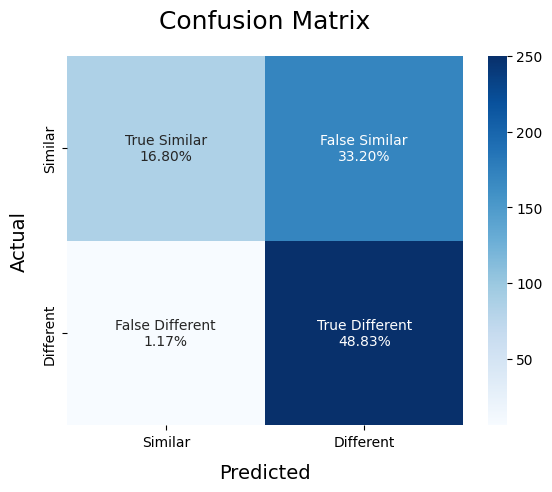

In [10]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

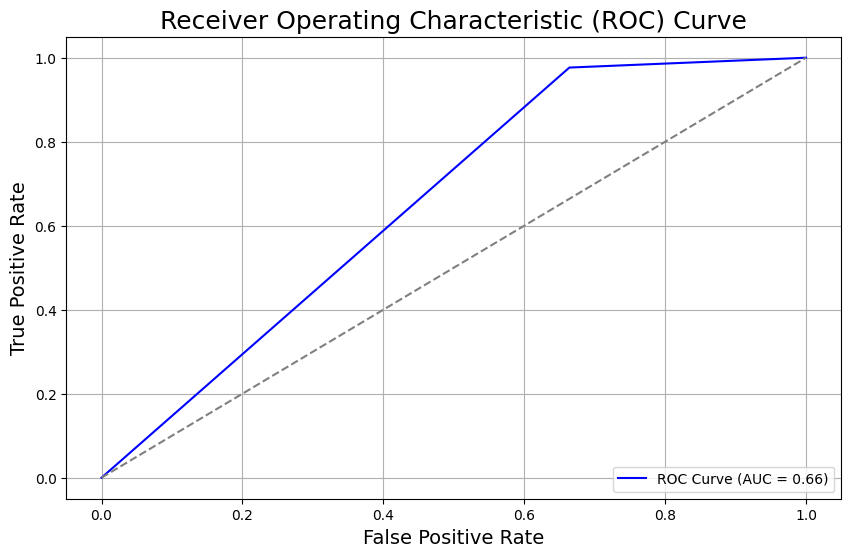

Best Threshold: 1.00


In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming face_list1, face_list2, pos_list, neg_list, and other required components are already defined.

def plot_roc_curve(true_labels, predictions):
    fpr, tpr, thresholds = roc_curve(true_labels, predictions)
    auc_score = roc_auc_score(true_labels, predictions)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Find the best threshold (Youden's J statistic)
    j_scores = tpr - fpr
    best_threshold_index = np.argmax(j_scores)
    best_threshold = thresholds[best_threshold_index]
    print(f'Best Threshold: {best_threshold:.2f}')

# Concatenate positive and negative lists to prepare for ROC curve calculation.
true_labels = np.array([0] * len(pos_list) + [1] * len(neg_list))
predictions = np.append(pos_list, neg_list)

# Plot the ROC curve and calculate the best threshold.
plot_roc_curve(true_labels, predictions)


In [26]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.stats import mode
from sklearn.cluster import KMeans

# Assuming 'encoder' is already defined and loaded with the correct weights

def detect_and_resize_face(image_path, new_size=(128, 128)):
    # Load the face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + './haarcascade_frontalface_default.xml')
    
    # Load the image and convert to grayscale
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        raise ValueError("No face detected in the image.")
    
    # Use the first detected face and add padding
    (x, y, w, h) = faces[0]
    padding = 20
    x1 = max(0, x - padding)
    y1 = max(0, y - padding)
    x2 = min(img.shape[1], x + w + padding)
    y2 = min(img.shape[0], y + h + padding)

    face_img = img[y1:y2, x1:x2]
    
    # Resize the face image
    face_img_resized = cv2.resize(face_img, new_size, interpolation=cv2.INTER_LANCZOS4)
    return face_img_resized

def augment_image(image):
    augmented_images = []
    # Original image
    augmented_images.append(image)
    
    # Rotate the image
    angles = [15, -15, 30, -30, 45, -45]
    for angle in angles:
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h))
        augmented_images.append(rotated)
    
    # Adjust brightness
    brightness_factors = [0.5, 0.75, 1.25, 1.5, 1.75]
    for factor in brightness_factors:
        bright = cv2.convertScaleAbs(image, alpha=factor, beta=0)
        augmented_images.append(bright)
    
    # Flip the image
    flipped = cv2.flip(image, 1)
    augmented_images.append(flipped)
    
    # Add Gaussian blur
    for kernel_size in [(3, 3), (5, 5)]:
        blurred = cv2.GaussianBlur(image, kernel_size, 0)
        augmented_images.append(blurred)
    
    # Add random noise
    for _ in range(5):
        noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
        noisy_image = cv2.add(image, noise)
        augmented_images.append(noisy_image)
    
    # Change contrast
    contrast_factors = [0.8, 1.2, 1.5]
    for factor in contrast_factors:
        contrast_img = cv2.convertScaleAbs(image, alpha=factor, beta=0)
        augmented_images.append(contrast_img)
    
    # Add salt-and-pepper noise
    for _ in range(5):
        sp_noise = image.copy()
        num_salt = np.ceil(0.02 * image.size * 0.5).astype(int)
        coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
        sp_noise[coords[0], coords[1], :] = 255
        num_pepper = np.ceil(0.02 * image.size * 0.5).astype(int)
        coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
        sp_noise[coords[0], coords[1], :] = 0
        augmented_images.append(sp_noise)
    
    return augmented_images

def register_face(face_images, user_id, user_name, encoder):
    embeddings = []

    for image_path in face_images:
        # Detect and resize face before embedding
        try:
            image = detect_and_resize_face(image_path)
        except ValueError as e:
            print(f"Skipping {image_path}: {e}")
            continue

        # Convert image to RGB and preprocess
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        augmented_images = augment_image(image)

        # Generate embeddings for all augmented images
        for aug_image in augmented_images:
            embedding = encoder.predict(np.expand_dims(aug_image, axis=0))
            embeddings.append(embedding)

    if len(embeddings) == 0:
        print("No valid face images for registration.")
        return

    # Use K-means clustering to find the most representative embedding
    embedding_array = np.vstack(embeddings)
    kmeans = KMeans(n_clusters=1, random_state=5).fit(embedding_array)
    final_embedding = kmeans.cluster_centers_[0]

    # Save the embedding as a .npy file
    if not os.path.exists("registered_faces"):
        os.makedirs("registered_faces")

    np.save(f"registered_faces/{user_id}_{user_name}.npy", final_embedding)
    print(f"Face for {user_name} (ID: {user_id}) registered successfully.")

def login_face(face_images, encoder, threshold=0.95):
    embeddings = []

    for image_path in face_images:
        try:
            image = detect_and_resize_face(image_path)
        except ValueError as e:
            print(f"Skipping {image_path}: {e}")
            continue

        # Convert image to RGB and preprocess
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        augmented_images = augment_image(image)

        # Generate embeddings for all augmented images
        for aug_image in augmented_images:
            embedding = encoder.predict(np.expand_dims(aug_image, axis=0))
            embeddings.append(embedding)

    if len(embeddings) == 0:
        print("No valid face images for login.")
        return False

    # Use K-means clustering to find the most representative embedding for login
    embedding_array = np.vstack(embeddings)
    kmeans = KMeans(n_clusters=1, random_state=0).fit(embedding_array)
    login_embedding = kmeans.cluster_centers_[0].astype(np.float32)

    # Load all registered embeddings
    registered_faces_dir = "registered_faces"
    if not os.path.exists(registered_faces_dir):
        print("No registered faces found.")
        return False

    matching_results = []
    for file_name in os.listdir(registered_faces_dir):
        registered_embedding = np.load(os.path.join(registered_faces_dir, file_name)).astype(np.float32)
        # Normalize both embeddings to ensure the cosine similarity is between -1 and 1
        login_embedding_norm = tf.math.l2_normalize(login_embedding, axis=0)
        registered_embedding_norm = tf.math.l2_normalize(registered_embedding, axis=0)
        similarity = tf.reduce_sum(login_embedding_norm * registered_embedding_norm)
        print(f"Comparing with {file_name}: Similarity = {similarity}")
        matching_results.append((file_name, similarity))

    # Find the most similar face
    matching_results.sort(key=lambda x: x[1], reverse=True)
    best_match = matching_results[0]
    print(f"Best match: {best_match[0]} with similarity {best_match[1]}")
    
    if best_match[1] >= threshold:
        return True
    else:
        return False
    
   

    
    

    

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input
from mtcnn.mtcnn import MTCNN
from sklearn.cluster import DBSCAN

# Assuming 'encoder' is already defined and loaded with the correct weights

def detect_and_resize_face(image_path, new_size=(128, 128)):
    # Load the MTCNN face detector
    detector = MTCNN()
    
    # Load the image and convert it to RGB
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at {image_path} not found.")
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Detect faces using MTCNN
    faces = detector.detect_faces(img_rgb)
    
    if len(faces) == 0:
        raise ValueError("No face detected in the image.")
    
    # Use the first detected face and add padding
    x, y, w, h = faces[0]['box']
    padding = 20
    x1 = max(0, x - padding)
    y1 = max(0, y - padding)
    x2 = min(img.shape[1], x + w + padding)
    y2 = min(img.shape[0], y + h + padding)

    face_img = img_rgb[y1:y2, x1:x2]
    
    # Resize the face image
    face_img_resized = cv2.resize(face_img, new_size, interpolation=cv2.INTER_LANCZOS4)
    return face_img_resized

def augment_image(image):
    augmented_images = [image]
    
    # Rotation angles
    angles = [15, -15, 30, -30, 45, -45]
    for angle in angles:
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h))
        augmented_images.append(rotated)
    
    # Adjust brightness
    brightness_factors = [0.5, 0.75, 1.25, 1.5, 1.75]
    for factor in brightness_factors:
        bright = cv2.convertScaleAbs(image, alpha=factor, beta=0)
        augmented_images.append(bright)
    
    # Flip image
    flipped = cv2.flip(image, 1)
    augmented_images.append(flipped)
    
    # Gaussian blur
    for kernel_size in [(3, 3), (5, 5)]:
        blurred = cv2.GaussianBlur(image, kernel_size, 0)
        augmented_images.append(blurred)
    
    return augmented_images

def register_face(face_images, user_id, user_name, encoder):
    embeddings = []

    for image_path in face_images:
        # Detect and resize face before embedding
        try:
            image = detect_and_resize_face(image_path)
        except ValueError as e:
            print(f"Skipping {image_path}: {e}")
            continue

        # Generate embeddings for all augmented images
        augmented_images = augment_image(image)
        for aug_image in augmented_images:
            aug_image_preprocessed = preprocess_input(np.expand_dims(aug_image, axis=0))
            embedding = encoder.predict(aug_image_preprocessed)
            embeddings.append(embedding)
    
    if len(embeddings) == 0:
        print("No valid face images for registration.")
        return

    # Stack embeddings
    embedding_array = np.vstack(embeddings)

    # Perform DBSCAN clustering
    db = DBSCAN(eps=0.5, min_samples=5).fit(embedding_array)

    # Find the core samples (non-outliers)
    core_samples_mask = db.labels_ != -1
    core_embeddings = embedding_array[core_samples_mask]

    if len(core_embeddings) == 0:
        print("No core embeddings found, unable to register face.")
        return

    # Compute the mean embedding of the core samples
    final_embedding = np.mean(core_embeddings, axis=0)

    # Save the embedding as a .npy file
    if not os.path.exists("registered_faces"):
        os.makedirs("registered_faces")

    np.save(f"registered_faces/{user_id}_{user_name}.npy", final_embedding)
    print(f"Face for {user_name} (ID: {user_id}) registered successfully.")

def login_face(face_images, encoder, threshold=0.6):
    embeddings = []

    for image_path in face_images:
        # Detect and resize face
        try:
            image = detect_and_resize_face(image_path)
        except ValueError as e:
            print(f"Skipping {image_path}: {e}")
            continue

        # Generate embeddings for all augmented images
        augmented_images = augment_image(image)
        for aug_image in augmented_images:
            aug_image_preprocessed = preprocess_input(np.expand_dims(aug_image, axis=0))
            embedding = encoder.predict(aug_image_preprocessed)
            embeddings.append(embedding)

    if len(embeddings) == 0:
        print("No valid face images for login.")
        return False

    # Stack embeddings
    embedding_array = np.vstack(embeddings)

    # Perform DBSCAN clustering on login embeddings to remove noise
    db = DBSCAN(eps=0.5, min_samples=5).fit(embedding_array)
    core_samples_mask = db.labels_ != -1
    core_embeddings = embedding_array[core_samples_mask]

    if len(core_embeddings) == 0:
        print("No core embeddings found for login.")
        return False

    # Compute the mean embedding of the login attempt
    login_embedding = np.mean(core_embeddings, axis=0)

    # Load all registered embeddings
    registered_faces_dir = "registered_faces"
    if not os.path.exists(registered_faces_dir):
        print("No registered faces found.")
        return False

    matching_results = []
    for file_name in os.listdir(registered_faces_dir):
        registered_embedding = np.load(os.path.join(registered_faces_dir, file_name))

        # Compute Euclidean distance
        distance = np.linalg.norm(login_embedding - registered_embedding)
        print(f"Comparing with {file_name}: Distance = {distance}")
        matching_results.append((file_name, distance))

    # Find the closest match (smallest distance)
    matching_results.sort(key=lambda x: x[1])
    best_match = matching_results[0]
    
    print(f"Best match: {best_match[0]} with distance {best_match[1]}")
    
    if best_match[1] <= threshold:
        user_id, user_name = best_match[0].split('_')[0], '_'.join(best_match[0].split('_')[1:]).replace('.npy', '')
        print(f"Login successful for user: {user_name} (ID: {user_id})")
        return True
    else:
        print("Login failed: No matching face found with sufficient similarity.")
        return False


In [14]:
# ตัวอย่างการใช้งาน
faceImage = [
    "./test/brad/brad1.jpg",
    "./test/brad/brad2.jpg",
    "./test/brad/brad3.jpg",
    "./test/brad/brad4.jpg",
    "./test/brad/brad5.jpg",
    "./test/brad/brad6.jpg",
    "./test/brad/brad7.jpg"
]

register_face(faceImage, user_id="001", user_name="Brad", encoder=encoder)

1/1 [==============================] - 0s 21ms/step
Face for Brad (ID: 001) registered successfully.


In [15]:
# ตัวอย่างการใช้งาน
faceImage = [
    "./test/dwayne/Dwayne1.jpg",
    "./test/dwayne/Dwayne2.jpg",
    "./test/dwayne/Dwayne3.jpg",
    "./test/dwayne/Dwayne4.jpg",
    "./test/dwayne/Dwayne5.jpg",
    "./test/dwayne/Dwayne6.jpg",
    "./test/dwayne/Dwayne7.jpg"
]

register_face(faceImage, user_id="002", user_name="Dwayne", encoder=encoder)

1/1 [==============================] - 0s 19ms/step
Face for Dwayne (ID: 002) registered successfully.


In [16]:
# ตัวอย่างการใช้งาน
faceImage = [
    "./test/tay/tay.jpg",
    "./test/tay/tay1.jpg",
    "./test/tay/tay2.jpg",
    "./test/tay/tay3.jpg",
    "./test/tay/tay4.jpg",
    "./test/tay/tay5.jpg",
    "./test/tay/tay6.jpg"
]

register_face(faceImage, user_id="003", user_name="taylor", encoder=encoder)

1/1 [==============================] - 0s 17ms/step
Face for taylor (ID: 003) registered successfully.


In [17]:
# ตัวอย่างการใช้งาน
faceImage = [
    "./test/olsen/olsen.jpg",
    "./test/olsen/olsen2.jpg",
    "./test/olsen/olsen3.jpg",
    "./test/olsen/olsen4.jpg",
    "./test/olsen/olsen5.jpg",
    "./test/olsen/olsen6.jpg",
    "./test/olsen/olsen7.jpg"
]

register_face(faceImage, user_id="004", user_name="olsen", encoder=encoder)

1/1 [==============================] - 0s 17ms/step
Face for olsen (ID: 004) registered successfully.


In [18]:
faceImage = [
    "./test/styles/styles1.jpg",
    "./test/styles/styles2.jpg",
    "./test/styles/styles3.jpg",
    "./test/styles/styles4.jpg",
    "./test/styles/styles5.jpg",
    "./test/styles/styles6.jpg",
    "./test/styles/styles7.jpg"
]
register_face(faceImage, user_id="005", user_name="styles", encoder=encoder)

1/1 [==============================] - 0s 18ms/step
Face for styles (ID: 005) registered successfully.


In [32]:
faceImage = [
    "./test/image6.jpg"
]

login_face(faceImage, encoder=encoder)


1/1 [==============================] - 0s 19ms/step
Comparing with 001_Brad.npy: Similarity = 0.8535752892494202
Comparing with 002_Dwayne.npy: Similarity = 0.7035959362983704
Comparing with 003_taylor.npy: Similarity = 0.7194174528121948
Comparing with 004_olsen.npy: Similarity = 0.6477299332618713
Comparing with 005_styles.npy: Similarity = 0.8328366279602051
Best match: 001_Brad.npy with similarity 0.8535752892494202


False

In [144]:
# shold be brad
faceImage = [
    "./test/brad/brad4.jpg",
    "./test/brad/brad5.jpg",
    "./test/brad/brad6.jpg"
]

login_face(faceImage, encoder=encoder)

1/1 [==============================] - 0s 20ms/step
Comparing with 001_Brad.npy: Similarity = 0.9798668026924133
Comparing with 002_Dwayne.npy: Similarity = 0.9908950328826904
Comparing with 003_taylor.npy: Similarity = 0.9942691922187805
Comparing with 004_olsen.npy: Similarity = 0.9718587398529053
Comparing with 005_styles.npy: Similarity = 0.9602951407432556
All matching results:
User: 001_Brad.npy, Similarity: 0.9798668026924133
User: 002_Dwayne.npy, Similarity: 0.9908950328826904
User: 003_taylor.npy, Similarity: 0.9942691922187805
User: 004_olsen.npy, Similarity: 0.9718587398529053
User: 005_styles.npy, Similarity: 0.9602951407432556
Login successful for user: taylor (ID: 003)


True

In [33]:
# shold be Dwayne
faceImage = [
    "./test/dwayne/Dwayne1.jpg",
    "./test/dwayne/Dwayne2.jpg",
    "./test/dwayne/Dwayne3.jpg"

]

login_face(faceImage, encoder=encoder)


1/1 [==============================] - 0s 18ms/step
Comparing with 001_Brad.npy: Similarity = 0.9341082572937012
Comparing with 002_Dwayne.npy: Similarity = 0.9862855672836304
Comparing with 003_taylor.npy: Similarity = 0.9749315977096558
Comparing with 004_olsen.npy: Similarity = 0.9491739869117737
Comparing with 005_styles.npy: Similarity = 0.9344509840011597
Best match: 002_Dwayne.npy with similarity 0.9862855672836304


True

In [34]:
# shold be taylor
faceImage = [
    "./test/tay/tay.jpg",
    "./test/tay/tay1.jpg"

]

login_face(faceImage, encoder=encoder)


1/1 [==============================] - 0s 25ms/step
Comparing with 001_Brad.npy: Similarity = 0.9336355924606323
Comparing with 002_Dwayne.npy: Similarity = 0.9713213443756104
Comparing with 003_taylor.npy: Similarity = 0.9830986261367798
Comparing with 004_olsen.npy: Similarity = 0.9576618075370789
Comparing with 005_styles.npy: Similarity = 0.9268372654914856
Best match: 003_taylor.npy with similarity 0.9830986261367798


True

In [35]:
# shold be olsen
faceImage = [
    "./test/olsen/olsen.jpg",
    "./test/olsen/olsen2.jpg",
    "./test/olsen/olsen3.jpg"
]

login_face(faceImage, encoder=encoder)


1/1 [==============================] - 0s 17ms/step
Comparing with 001_Brad.npy: Similarity = 0.7562234401702881
Comparing with 002_Dwayne.npy: Similarity = 0.829364001750946
Comparing with 003_taylor.npy: Similarity = 0.8339594006538391
Comparing with 004_olsen.npy: Similarity = 0.9532102942466736
Comparing with 005_styles.npy: Similarity = 0.751390814781189
Best match: 004_olsen.npy with similarity 0.9532102942466736


True

In [36]:
# shold be styles   
faceImage = [

    "./test/styles/styles2.jpg",
    "./test/styles/styles3.jpg"
]

login_face(faceImage, encoder=encoder)


1/1 [==============================] - 0s 16ms/step
Comparing with 001_Brad.npy: Similarity = 0.8937429189682007
Comparing with 002_Dwayne.npy: Similarity = 0.8251953721046448
Comparing with 003_taylor.npy: Similarity = 0.8092113733291626
Comparing with 004_olsen.npy: Similarity = 0.7629565596580505
Comparing with 005_styles.npy: Similarity = 0.9114046692848206
Best match: 005_styles.npy with similarity 0.9114046692848206


False